# Creating a Custom PyTorch Dataset Class
PyTorch provides a Dataset class that we can work with for batching during model training.
We will begin by creating our own custom Dataset class that inherits from the base PyTorch Dataset class.
Once we have our custom Dataset class, we can use the PyTorch Dataloader module to index our data for training, evaluation, and testing.
The official [PyTorch Tutorial](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html) contains detailed information and links to the official documentation for both the Dataset and Dataloader class.

We will start by defining our Dataset class and then explain what each function does.
Afterwards, we'll create some Dataloaders using our custom Dataset class and then load a few examples to verify our code is working correctly

## Custom Fruits Dataset Class

In [36]:
import torch
from torchvision.io import read_image
from torch.utils.data import Dataset
from torchvision.transforms.functional import convert_image_dtype
import pandas as pd

In [3]:
# The dataset class requires us to implement at least the __getitem__ and __len__ functions
class FruitsDataset(Dataset):
    def __init__(self, annotations_file: str, img_dir: str, transform=None, target_transform=None):
        self.data_df = pd.read_csv(annotations_file, encoding='utf-8', engine='python')
        self.img_dir = img_dir
        self.img_labels = self.data_df['label']
        self.img_ids = self.data_df['filename'].unique()  # Use the image file name as the ID for each image
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return self.img_ids.shape[0]

    def __getitem__(self, index: int):
        img_id = self.img_ids[index]

        # The full file path to the image
        img_path = self.img_dir + img_id

        # Select all rows in our data frame that contain entries for the image at location data_df[index]
        img_annotations = self.data_df.loc[self.data_df['filename'] == img_id]

        # Get the boxes and labels for our image
        # Convert them to torch tensors so we can use them in our dataloader
        boxes = img_annotations[['x1', 'y1', 'x2', 'y2']].values
        # Get the area of all the boxes. The [:, 3] notation says to give me the entire column at column index 3
        # and so on. This is numpy shorthand for subtracting and multiplying entire columns of arrays
        # The area equation is w*h, and we will have an n-element matrix where each entry is the area of
        # the bounding box for the nth object
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        boxes = torch.as_tensor(boxes, dtype=torch.int)
        area = torch.as_tensor(area, dtype=torch.float32)
        labels = img_annotations['label'].values
        labels = [self.__convert_labels__(x) for x in labels]
        labels = torch.as_tensor(labels)

        # Read the image using torchvision so we can return it
        image = read_image(img_path)
        image = convert_image_dtype(image, torch.float)

        # Apply any transforms if they were supplied
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            labels = self.target_transform(labels)

        # Add the results for our image to a dictionary. This dictionary will hold the
        # box, labels, and area of our box
        target = {'boxes': boxes,
                  'area': area,
                  'labels': labels,
                  'img_id': img_id}

        return image, target

    def __convert_labels__(self, x):
        # This function will convert our string labels into integer values
        # Torch will now allow creating a tensor using strings so our workaround will be
        # to use this encoding.
        # Remember, torch reserves 0 for the "background class" so we start at 1
        encoding = {'apple': 1, 'banana': 2, 'orange': 3}
        converted_label = encoding[x]
        return converted_label

## Explanation of our Custom Dataset Class

### `__init__()` function
This function is called whenever we create an instance of our Dataset.
We pass to it an annotations file path and an image directory file path.
The optional `transform` and `target_transform` arguments can be supplied.
If you wanted to perform some operations such as cropping, rotation, etc on our input images, we would pass that to the `transform` argument.
If we wanted to perform a transform on the data returned from our `__getitem()__` function, we would pass that in to the `target_transform` argument.

We begin by loading our annotations file that we created in our `create_dataset.ipynb` notebook into a dataframe using Pandas and store it in `self.data_df`.
We store the `img_dir` variable to our class in a `self.img_dir` variable.
We will use this variable later on to load images.
From our `self.data_df` dataframe, we extract the labels for each image and store them in `self.img_labels`.
`self.img_labels` are our target outputs for each image in the data set.
Our Dataset class requires a way to index each item we load.
For this, we will use the unique list of image filenames by calling `self.data_df['filename'].unique()` and we store them in `self.img_ids`.
We will see below that `self.img_ids` will be used in `__getitem()__` to index our data.
Finally, we store any arguments supplied for `transform` or `target_transform` in `self.transform` and `self.target_transform` respectively

### `__len__()__` function
Our `__len()__` function simply returns the length of our dataset.
The length corresponds to the number of images of our dataset, so we return the length of our image IDs which is stored in: `self.img_ids.shape[0]`.

### `__getitem__()` function
This is our meat and potatoes function for our custom Dataset class.
Whenever we use a PyTorch DataLoader, this function is called to return $n$ samples from our data.
$n$ samples corresponds to the batch size we supply to the DataLoader object, we will discuss the DataLoader in detail later on.

We see that `__getitem__()` receives an integer index as input.
This value is generated on the fly when using a DataLoader.
However, this index value will correspond to an entry in our `self.img_ids` variable, so the first thing we do extract the corresponding image ID from our dataframe using the index.
If we look above, we see that `self.img_ids` are just the unique filenames contained in our data set.
With this in mind, we can select all rows in our dataframe that correspond to the image using Pandas: `self.data_df.loc[self.data_df['filename'] == img_id]`.
We store this value in an `img_annotations` variable and this variable is a subset of the entire data frame that contains only entries that correspond to our image ID.

We use our `self.img_dir` variable and combine it with the `img_id`, which is just an image filename, to create a `img_path` variable that we'll use to load an image.

Given that we have our `img_annotations` subset, we can now pull the bounding boxes and labels for that particular image.
For our bounding boxes, we use `img_annotations[['x1', 'y1', 'x2', 'y2']].values` to pull out the coordinates for each box in our data frame and store them as a list in the `boxes` variable.
The `boxes` variable is a matrix of values where each row represents a box with `[x1,y1,x2,y2]` in the columns.
For computing our scoring metrics, it's possible we need the area of each bounding box.
For this we use Numpy indexing and perform operations across columns of our matrix and store it in the `area` variable: `area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])`.
As noted in the comments, our Numpy indexing allows us to compute the area of all boxes in the matrix at once.
So our `area` calculation is simply the $W*H$ calculation for each bounding box in our matrix.
Finally, we need to represent our bounding box matrix as a `torch.tensor()` variable of type integer.
To do this we just need to cast our Numpy bounding box matrix: `boxes = torch.as_tensor(boxes, dtype=torch.int)`.
We do the same thing with the `area` variable as well: `area = torch.as_tensor(area, dtype=torch.float32)`.

For our labels, we need to extract the labels from our `img_annotations` subset: `labels = img_annotations['label'].values`.
The `.values` call retrieves the label string values without the index, i.e. get only the values from the Pandas series.
We apply our `__convert_labels__()` function to our list of labels, which maps our string labels to an integer value.
PyTorch does not allow creating a tensor variable out of strings, hence the conversion to integers
Afterwards, we convert our labels to a PyTorch tensor using: `labels = torch.as_tensor(labels)`.

We create an `image` variable using the built in `read_from_image()` function in `torchvision.io.read_from_image` module.
This image will be returned alongside our dictionary of desired outputs (targets).
Our FasterRCNN model requires values to be floats in the range (0-1) but `read_from_image` loads values in the range (0-255). We can use the `convert_image_dtype` function on this image to change the uint8 (0-255) values to floating points in the range (0-1).

Next, we use our `self.transform` and `self.target_transform` variables to apply transforms to our image and labels, respectively, if any transforms were supplied during class instantiation.

Finally, we create a dictionary, `target` that houses our bounding boxes, area, labels and image ID for our image and then return our image and target output using `return image, target` to return a tuple.

## `__convert_labels__()` function
As mentioned above, PyTorch does not allow the creation of tensor variables using strings.
This poses a problem for us since our annotation labels are all strings.
To get around this problem, we can cast our string labels to integers so that we can have valid classification labels to work with in our training.
The `encoding` dictionary simply maps all of our classes into corresponding integer values.
Notice that the integer values start at 1 and not 0.
This is because PyTorch reserves the class label 0 for the background class in some models.
We will be fine-tuning a Faster-RCNN model and this particular model does reserve 0 as the background class.

To convert each label, we simply take the supplied input `x` which will be one of `[apple, orange, banana]` and map it to an integer value using: `converted_label = encoding[x]` and return the corresponding integer value.

## Testing our Dataset Class using DataLoaders
Now that we have defined and explored our Dataset custom class, we can test it out using a DataLoader.

In [8]:
# Import necessary libraries
from torch.utils.data import DataLoader
import torch
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F
from torchvision.utils import draw_bounding_boxes
import cv2

In [5]:
# Specify our image directory and annotations file. We'll use the train folder for this.
train_img_dir = './data/fruits/train/'
train_annotations_file = './data/fruits/train/annotations.csv'

### Collate Function
PyTorch allows you to specify a collate function for batching with a DataLoader.
It is good practice to specify at least a simple one to avoid errors.
For example, if you try to load a batch of 2 images from our dataset where image 1 has 2 annotations and image 2 only has 1 annotation, the PyTorch DataLoader will throw an error when trying to create a tensor with mis-matched dimensions.
This very simple collate function avoids those errors.

In [6]:
def collate_fn(batch):
    return tuple(zip(*batch))

### Display Results Using TorchVision
The Torchvision module contains easy-to-use built in functionality for drawing bounding boxes on our images.
Unfortunately, our fruits dataset images contain some images that do not have the correct format.
This is a known issue with the downloaded data, so if you do happen to get an error when using our TorchVision visualization function, no need to panic.

The OpenCV visualization code does work fine on our dataset, so you should encounter no issues when running it

In [7]:
def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

### Display Results Using OpenCV

In [34]:
def show_cv(img_name, boxes, labels):
    img_path = train_img_dir + img_name
    img = cv2.imread(img_path, cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    for box, label in zip(boxes, labels):
        cv2.rectangle(img, (box[0], box[1]), (box[2], box[3]), (255, 0, 0), 2)
        cv2.putText(img, label, (box[0], box[1]), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 0))
    plt.imshow(img)

### Create an Instance of Our Dataset Class and Load into a DataLoader

In [10]:
batch_size = 1  # Change this to load n samples in the dataloader each step

In [11]:
train_dataset = FruitsDataset(train_annotations_file, train_img_dir)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)

When we create a DataLoader, we simply need to pass it a Dataset class (our custom fruits dataset), a batch size (number of samples to load per step), a boolean shuffle value (reorder the dataset for sampleing on each step), and a collate function (how to combine the data after sampling).

In [12]:
train_images, train_targets = next(iter(train_dataloader))

In [13]:
train_targets

({'boxes': tensor([[113, 258, 583, 700]], dtype=torch.int32),
  'area': tensor([207740.]),
  'labels': tensor([1]),
  'img_id': 'apple_17.jpg'},)

We see that we sampled 1 data point from our Fruits Dataset, and we have its bounding boxes, area, labels and image ID.
Let's use this information to display our image using Torchvision and OpenCV

In [17]:
boxes = train_targets[0]['boxes']
boxes

tensor([[113, 258, 583, 700]], dtype=torch.int32)

In [19]:
labels = train_targets[0]['labels']
labels

tensor([1])

In [20]:
# Define a colors dictionary to map back between class integers and a bounding box color
colors_dict = {1: 'red', 2: 'yellow', 3: 'orange'}

In [22]:
# Define a labels dictionary to use with OpenCV to map between the class integers and corresponding labels
cv_labels_dict = {1: 'apple', 2: 'banana', 3: 'orange'}

In [23]:
# Create a list of colors for use with TorchVision visualization
colors = [colors_dict[int(l)] for l in labels]

# Create a list of labels for use with OpenCV visualization
cv_labels = [cv_labels_dict[int(l)] for l in labels]


In [30]:
# Get our Image and Image ID for visualization
img = train_images[0]
img_name = train_targets[0]['img_id']

'apple_17.jpg'

In [31]:
torchvision_result = draw_bounding_boxes(img, boxes, colors=colors, width=2)

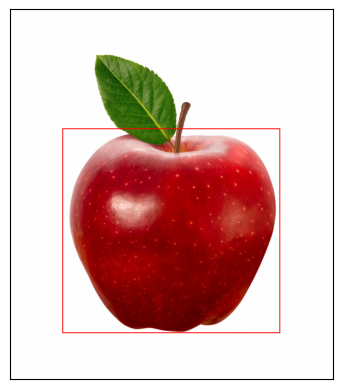

In [32]:
show(torchvision_result)

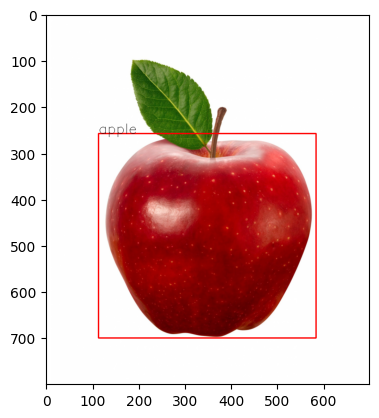

In [35]:
show_cv(img_name, boxes.tolist(), cv_labels)

## And That's It!
Now we have our custom dataset class that can be used with a data loader.
The `fruits_dataset.py` and `fruits_data_test.py` scripts detail how to use these in a more traditional script fashion.
We will now move on to using these to perform our model fine-tuning!